In [1]:
# Finding the two closest SOTA summits

In [2]:
%pylab inline
import pandas as pd
# We need to use pyppeteer and asyncio to get the data from the sota pages as they are js generated
import time
from geopy import distance
from math import sin, cos, sqrt, atan2, radians
from scipy.spatial.distance import cdist
import math
import numpy as np

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
# SOTA
url="https://www.sotadata.org.uk/summitslist.csv"

dtype={"GridRef1": "string", "GridRef2": "string"}
names=["SummitCode", "AssociationName", "RegionName", "SummitName", 
       "AltM", "AltFt", "GridRef1", "GridRef2", "Longitude", "Latitude", "Points",
       "BonusPoints", "ValidFrom", "ValidTo", "ActivationCount", "ActivationDate",
       "ActivationCall"]

sotadf=pd.read_csv(url, skiprows=2, names=names, dtype=dtype)


In [4]:
# Simple function to plot the lat,long into a 3D cartesian spherical space.
# Yea the world isn't a sphere, don't think that matters here too much
def get_cartesian(lat=None,lon=None):
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    R = 6371 # radius of the earth
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R *np.sin(lat)
    return x,y,z



In [10]:
# Quick test for EI
# we with cartesian coords we call scipy cdist on the points
# This gives us a matrix of all the distances between all points
# We then find the minimum nonzero value
testdf = sotadf[sotadf.AssociationName == "Ireland"]
foo=testdf.copy()
foo["i"]=testdf.apply(lambda x: get_cartesian(x['Latitude'], x['Longitude']), axis=1)
foo["x"] = foo.apply(lambda x: x["i"][0], axis=1)
foo["y"] = foo.apply(lambda x: x["i"][1], axis=1)
foo["z"] = foo.apply(lambda x: x["i"][2], axis=1)

x = foo[["x","y","z"]]
tmp=cdist(x,x)
i,j = np.where( tmp==np.min(tmp[np.nonzero(tmp)]))
print(testdf.iloc[i], testdf.iloc[j])
print(np.min(tmp[np.nonzero(tmp)]))

      SummitCode AssociationName    RegionName    SummitName  AltM  AltFt  \
14479  EI/IW-014         Ireland  Ireland West  Binn Bhraoin   691   2267   
14484  EI/IW-019         Ireland  Ireland West   Binn Gabhar   664   2178   

       GridRef1 GridRef2  Longitude  Latitude  Points  BonusPoints  \
14479  L 783515     <NA>   -9.83471  53.49961       8            3   
14484  L 783506     <NA>   -9.83436  53.49153       8            3   

        ValidFrom     ValidTo  ActivationCount ActivationDate ActivationCall  
14479  15/03/2003  31/12/2099                5     04/06/2023        EI3KA/P  
14484  15/03/2003  31/12/2099                5     04/06/2023        EI3KA/P         SummitCode AssociationName    RegionName    SummitName  AltM  AltFt  \
14484  EI/IW-019         Ireland  Ireland West   Binn Gabhar   664   2178   
14479  EI/IW-014         Ireland  Ireland West  Binn Bhraoin   691   2267   

       GridRef1 GridRef2  Longitude  Latitude  Points  BonusPoints  \
14484  L 783506   

In [ ]:
# As above but go association by association

# Running cdist takes about 225G of memory and 400G or so to find the min distance, 
# though python falls over before this (on an EC2 w/ 512Gb anyway)

testdf = sotadf.copy()
foo=testdf.copy()
foo["i"]=testdf.apply(lambda x: get_cartesian(x['Latitude'], x['Longitude']), axis=1)
foo["x"] = foo.apply(lambda x: x["i"][0], axis=1)
foo["y"] = foo.apply(lambda x: x["i"][1], axis=1)
foo["z"] = foo.apply(lambda x: x["i"][2], axis=1)

sotadf=foo

associations = list(set([x for x in sotadf.AssociationName]))
associations.sort()
mindist = -1
fres = None
for association in associations:
    print("Checking... " + association)
    testdf = sotadf[sotadf.AssociationName == association]
    x = testdf[["x","y","z"]]
    try:
        tmp=cdist(x,x)
        i,j = np.where( tmp==np.min(tmp[np.nonzero(tmp)]))
        print("have min")
    except:
        continue
    res = (testdf.iloc[i], testdf.iloc[j])
    dist = np.min(tmp[np.nonzero(tmp)])
    print(dist)
    print(mindist)
    if dist < mindist or mindist == -1:
        mindist = dist
        fres = res
    print(fres)
    print(mindist)

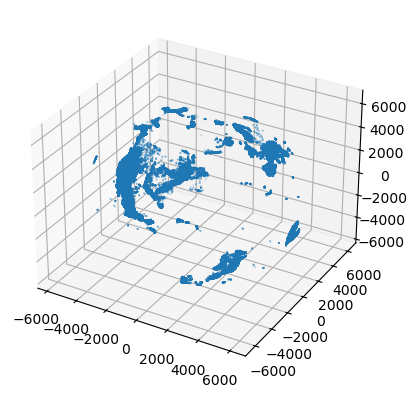

In [100]:
# Just to chow that our cartesian coords are somewhat right we can plot them all
# Looks kinda like the globe...
def create_3d_scatter(df):
    import matplotlib.pyplot as plt
    import numpy as np
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df['x'], df['y'], df['z'],s=.1)
    plt.show()

create_3d_scatter(x)

In [ ]:
# Anyway, closest are:
"""
45202  KLA/MW-190  Alaska - Anchorage  MATANUSKA-SUSITNA WEST       7450  2271   7450  -152.7409  62.4537 -152.74091   62.4537       8            3  01/03/2016  01/01/2099                0            NaN            NaN  (-2619.155882356007, -1349.4797168822618, 5648... -2619.155882 -1349.479717  5648.766941
45189  KLA/MW-177  Alaska - Anchorage  MATANUSKA-SUSITNA WEST       7550  2301   7550  -152.7427  62.4555 -152.74271   62.4555       8            3  01/03/2016  01/01/2099                0            NaN            NaN  (-2619.0405191755963, -1349.3161573929701, 564... -2619.040519 -1349.316157  5648.859501)
0.2205169598002028
"""